In [1]:
import pandas as pd 
import seaborn as sns
import nltk

import re
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from pandarallel import pandarallel 

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alenvlahovljak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- Load dataset

In [3]:
df = pd.read_csv('./tweets.csv', header=None, encoding='ISO-8859-1', names=["target", "id", "date", "flag", "user", "text"])

- Init parallel processsing

In [4]:
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


- Get first five rows

In [5]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<h3>Prepocessing</h3>

- Drop irrelevant columns

In [6]:
df.drop(columns = 'flag', axis = 1, inplace = True)
df.tail()

,target,id,date,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


- Print dataframe size

In [7]:
df.size

8000000

- Plot <code>target</code> distribution

<AxesSubplot:xlabel='target', ylabel='count'>

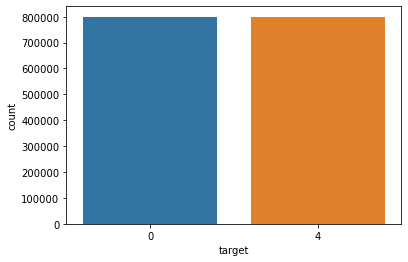

In [8]:
sns.countplot(x='target', data=df)

- Shuffle data and take 500,000 tweets

In [9]:
df = shuffle(df, random_state=42)
df = df[1:5000]

- Print unique values of <code>target</code>

In [10]:
df['target'].unique()

array([0, 4])

- Count unique <code>target</code> values

In [11]:
df['target'].value_counts()

4    250625
0    249374
Name: target, dtype: int64

- Cleaning the <code>text</code>

In [12]:
def text_clean(text):
    review = re.sub('[^a-zA-Z]',' ', text) 
    review = review.lower()
    review = review.split()
    
    ps = LancasterStemmer()
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    
    return ' '.join(review)

In [13]:
df['text'] = df['text'].parallel_apply(lambda x: text_clean(x))
df

,target,id,date,user,text
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,sexygrneyes,misstoriblack cool tweet ap razr
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,sammydearr,tiannachao know famy dram lam hey next tim u h...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,Lamb_Leanne,school email op geograph stuff rev stupid school
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,yogicerdito,up airway problem
379611,0,2052380495,Sat Jun 06 00:32:16 PDT 2009,Yengching,going miss past sermon fai
...,...,...,...,...,...
1085389,4,1969163759,Fri May 29 23:12:12 PDT 2009,Izaaza,going katuty pamp
753135,0,2286778000,Mon Jun 22 16:54:48 PDT 2009,sega_123,jeanet sick tak nap broth fly cal tuesday
466554,0,2175587755,Mon Jun 15 01:24:51 PDT 2009,din_heima,wann mak eg custard coconut milk tot fail
1471328,4,2065195932,Sun Jun 07 08:05:55 PDT 2009,AliciaSanera,employerbrand shh read pap sunday


- Integer encoding

In [14]:
encoder = LabelEncoder()

y = df['target']

encoder.fit(y)
Y = encoder.transform(y)

- Data split into training and testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], Y, test_size = 0.30, random_state = 0)

- K-fold cross validation, k = 5

In [16]:
from sklearn.model_selection import cross_val_score 

def evaluation(model, X_test,  y_test):
    y_pred = model.predict(X_test)
    
    score = cross_val_score(model, X_test, y_test, cv = 5)
    
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

- TF-IDF Vectorizer (max_features = 2000 most frequent words)

In [17]:
tfidf = TfidfVectorizer(max_features = 2000)

X_train_tf = tfidf.fit_transform(X_train).toarray() 
X_test_tf = tfidf.transform(X_test).toarray()

- Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train_tf, y_train)

y_pred_dtc = dtc.predict(X_test_tf)

- Evaluate model

In [ ]:
evaluation(dtc, X_test, Y_test)

- Accuracy:

In [ ]:
accuracy_score(y_test, y_pred_dtc)

- Confusion Matrix 

In [ ]:
confusion_matrix(y_test, y_pred_dtc)

- Classification Report

In [ ]:
classification_report(y_test, y_pred_dtc)